# Paper Replicating: The Vision Transformer (ViT)

In this workbook, I will be replicating the ViT architecture as explained in the machine learning research paper: ***"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"***.
Link to paper in arXiv: https://arxiv.org/abs/2010.11929

I will create a smaller model than what the paper describes given hardware constraints. For example, the paper states the batch size to train the model should be 1024, whereas I will create the training loop with a batch size of 32.


As dataset, I will use 20% of the Food101 dataset from `torchvision`, where I will only be considering images of pizza, steak and sushi.

The workbook will be split in 3 main stages:

* Stage 1:
 - Get setup: install packages, libraries
 - Get data: create directory and download and unzip data if it doesn't already exist
 - Create Datasets and DataLoaders
* Stage 2:
 - Overview of the ViT architecture's key components: patch & positional embedding, Multi-Head Self-Attention, Multilayer Perceptron
 - Re-create all individual components above
 - Combine all components above to form the Transformer Encoder
* Stage 3:
 - Set up the training loop and train our new model
 - Get pre-trained ViT models
 - Evaluate the models we have
 - Test predictions on custom images (not on test data)
* Stage 4:
 - Create a Python script for the ViT ('vit.py') to have it ready for any future projects 

**NOTE**: I will run the code on a CPU. To run it on a GPU, need to set up device-agnostic code and apply it to the dataset, model and sample images using PyTorch's `.to(device)` where `device = "cuda" if torch.cuda.is_available() else "cpu"`

## Stage 1: Getting setup (packages, data, Datasets and DataLoaders)

### Stage 1.1: Packages and libraries (might need more later)

In [61]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchmetrics
import requests
import os
import torch.utils.tensorboard
import zipfile
import random

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from pathlib import Path
from timeit import default_timer as timer

### Stage 1.2: Create data directory and download data

In [2]:
# Let's set up the data directory and download data if it doesn't already exist

base_dir = Path('data')
image_dir = base_dir / 'pizza_steak_sushi_20perc'

if image_dir.is_dir():
    print(f"[INFO] Directory {image_dir} already exists")
else:
    # 1. Make directory
    print(f"[INFO] Directory does not exist, creating it now!")
    image_dir.mkdir(parents=True, exist_ok=True)
    
    # 2. Download data
    with open(base_dir / "pizza_steak_sushi_20perc.zip", "wb") as f:
        print(f"[INFO] Downloading raw data...")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
        f.write(request.content)
        
    # 3. Unzip file
    with zipfile.ZipFile(base_dir / "pizza_steak_sushi_20perc.zip", "r") as zip_ref:
        print("Unzipping data (20% of Food101 images for pizza, steak and sushi only)...")
        zip_ref.extractall(image_dir)
        
    # 4. Delete zip file
    print(f"[INFO] Removing the zip file. We have already extracted the content!")
    os.remove(base_dir / "pizza_steak_sushi_20perc.zip")

[INFO] Directory does not exist, creating it now!
[INFO] Downloading raw data...
Unzipping data (20% of Food101 images for pizza, steak and sushi only)...


### Stage 1.3: Transform data into tensors, create Datasets and DataLoaders

In [3]:
# Setup train and test directories
train_dir = image_dir / "train"
test_dir = image_dir / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20perc/train'),
 WindowsPath('data/pizza_steak_sushi_20perc/test'))

In [4]:
# Create data transforms - turn images into tensor format
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # also convert images to 224x224 pixels
    transforms.ToTensor()
])

print(f"Our simple transforms: {simple_transform}")

Our simple transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [5]:
# Create train and test Datasets using torchvision's ImageFolder() 
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, 
                                                 transform=simple_transform, 
                                                 target_transform=None)


test_dataset = torchvision.datasets.ImageFolder(root=test_dir, 
                                                transform=simple_transform, 
                                                target_transform=None)

len(train_dataset), len(test_dataset)

(450, 150)

In [9]:
# Let's save the classes as per the ImageFolder
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

In [7]:
# Turn our Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=32, 
                              shuffle=True, 
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset, 
                             batch_size=32, 
                             shuffle=True, 
                             pin_memory=True)

len(train_dataloader), len(test_dataloader)

(15, 5)

In [11]:
# Let's see a single image from our training set
image_batch, label_batch = next(iter(train_dataloader))

# Get the first image from the batch
image, label = image_batch[0], label_batch[0]

print(f"Image has shape: {image.shape}")
print(f"Label: {label} ~ {class_names[label]}")

Image has shape: torch.Size([3, 224, 224])
Label: 2 ~ sushi


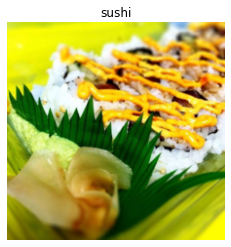

In [13]:
# Let's view it using matplotlib
plt.imshow(image.permute(1, 2, 0)) #matplotlib requries color channels last - consistent to how Numpy puts images as arrays
plt.title(class_names[label])
plt.axis(False);

## Stage 2: Re-creating the ViT components and full architecture

The ViT architecture is comprised of several stages:
* **Patch Image and add Positional Embedding** 
 - Turn the input image into a sequence of image patches and add a position number to specify the order that these patches come in
 - Recall that the Transformer was originally created to handle 1D data (e.g., text), which is why we have to convert the image into a sequence of patches.
* **Linear projection of flattened patches (turn the patches into embeddings)**
 - To turn an image into an embedding means to find a numerical representation of the image (typically in the form of a high-dimensional vector).
 - The benefit of using an embedding rather than just the image values is that an embedding is a learnable representation of the image that can improve with training.
* **Layer Normalization**
 - Used to regularize the model - i.e., combat overfitting.
* **Multi-Head Attention**
* **MLP (Multilayer Perceptron)**
* **Transformer Encoder** 
 - The Transformer Encoder is comprised of the layers listed above.
 - In the ViT architecture, the Encoder is repeated multiple times before sending the output to the MLP Head which in turn gets us the classification prediction.
* **MLP Head**
 - This is the output layer of the architecture, it converts the learned features of an input to a class output.


We will use the smallest ViT model with 12 Transformer Encoders, 786-dimensional Embeddings, and 12 self-attention heads!

This leads to about 86M parameters

### Stage 2.1: Create image patches, get embedding + positional embedding

To understand the shapes going in and out this stage:
- D is the size of the patch embeddings - we will use the 768-dimensional embedding
- The image starst as 2D with size Height x Width x Color Channels (H x W x C)
 - (H, W) is the resolution of the original image
- The image gets converted to a sequence of flattened 2D patches with size N x (P^2 * C)
 - (P, P) is the resolution of each image patch (P = patch size)
 - N = HW/P^2 is the resulting number of patches, which also serves as the input sequence length for the Transformer
 - For example, if patch size is 16 (P=16), and the image resolution is 224x224, then there are 196 patches of size 16x16 in the 224x224 image.
 - Now, the resulting tensor after the embedding, will have shape [196, 16 * 16 * 3] = [196, 768]
 - In other words, the 196 patch images of size [16x16x3] have been flattened, which results in a tensor of shape [196, 768] 

In [15]:
# Let's re-create the explanation above - image resolution is 224x224 pixels (HxW)
height = 224 # H
width = 224 # W
color_channels = 3 # color image
patch_size = 16 # P

# N ~ number of patches
number_of_patches = int((height * width) / patch_size**2)

print(f"Image with {height}x{width} pixels is composed of {number_of_patches} patches of size {patch_size}x{patch_size}")

Image with 224x224 pixels is composed of 196 patches of size 16x16


In [16]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Let's view some images and image patches

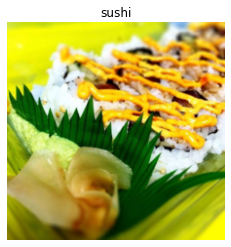

In [18]:
# Open the same image as above
image_permuted = image.permute(1, 2, 0)

plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False);

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16x16 pixels


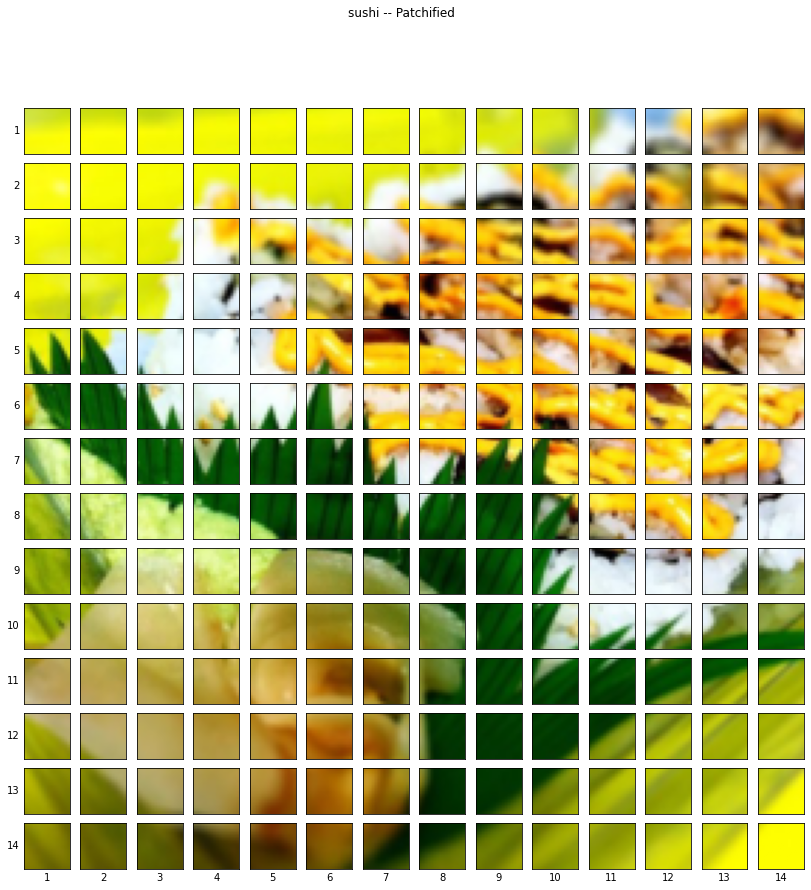

In [23]:
# Let's break it down into patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches per row: {num_patches}")
print(f"Number of patches per column: {num_patches}")
print(f"Total patches: {num_patches*num_patches}")
print(f"Patch size: {patch_size}x{patch_size} pixels")

# Create subplots
fig, axs = plt.subplots(nrows=int(num_patches), 
                        ncols=int(num_patches), 
                        figsize=(num_patches, num_patches), 
                        sharex=True, 
                        sharey=True)

# Loop through the image to create the patches
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted image
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, 
                                        patch_width:patch_width+patch_size, 
                                        :])
        
        # Set up label information
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
        
# Set a super title
fig.suptitle(f"{class_names[label]} -- Patchified")
plt.show;

#### Stage 2.1.1: Preparing the patch embedding

The idea of patchifying an image is similar to what a convolutional layer does through its kernel window.

The patch embedding can therefore be done using a convolutional layer - the convolutional layer slides a learnable kernel across each patch. Through the learnable kernel, we can learn the patch embedding.

Steps through an example:
- Suppose the patch dimension is 16x16 pixels
- Therefore, we need to set our kernel to be 16x16 pixels, and the stride to be 16
- If the image is 224x224, then the resulting output feature map will have size 14x14 (224 / 16 = 14)
- Also, the number of output features from the convolutional layer should be equal to the embedding dimension D (768)
- Therefore, the output from the convolutional layer will have a shape of (768, 14, 14)
- Next, we would need to flatten the last two dimensions to turn the shape into (768, 196) - since the Transformer architecture is built to handle 1D data
- Finally, permute the order of the output such that we turn the shape into (196, 768)
 - ***196*** represents the order with which the information goes into the model
 - ***768*** represents the embedding dimensionality - basically for each patch (16x16), we have 768 information points

In [26]:
# Let's create the convolutional layer
from torch import nn

# Set the patch size & embedding dimension
patch_size = 16
emb_dim = 768

# Convolutional Layer
conv2d = nn.Conv2d(in_channels=3, 
                   out_channels=emb_dim, 
                   kernel_size=patch_size, 
                   stride=patch_size, 
                   padding=0)

In [27]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


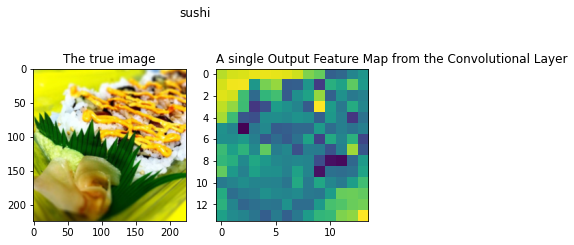

In [49]:
# Let's plot the image and one of the feature maps side by side
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("The true image")

example_feature_map = image_out_of_conv[:,0,:,:]

plt.subplot(1, 2, 2)
plt.imshow(example_feature_map.permute(1, 2, 0).detach().numpy())
plt.title("A single Output Feature Map from the Convolutional Layer", loc='left')


plt.suptitle(class_names[label], );

In [56]:
# Now, we also have to flatten the last two dimensions of the output from the convolutional layer
image_out_of_conv_flattened = torch.flatten(image_out_of_conv, start_dim=2, end_dim=3)
print(f"Patch embedding shape: {image_out_of_conv.shape} --> {image_out_of_conv_flattened.shape}")

Patch embedding shape: torch.Size([1, 768, 14, 14]) --> torch.Size([1, 768, 196])


In [57]:
# Fixing the order of the dimensions
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Finalized patch embedding shape: {image_out_of_conv_flattened_reshaped.shape}")

Finalized patch embedding shape: torch.Size([1, 196, 768])


Now will create a PyTorch module that does all of the steps above

In [59]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels: Number of input channels (3 for RBG image)
        patch_size: Size of patches to convert the input image into
        embedding_dim: Size of embedding to turn image into
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=embedding_dim, 
                                 kernel_size=patch_size, 
                                 stride=patch_size, 
                                 padding=0)
        
        # 4. Flatten the last two dimensions of the output from the patcher layer
        self.flatten = torch.nn.Flatten(start_dim=2, 
                                        end_dim=3)
        
        
    # 5. Define the forward method
    def forward(self, x):
        # Create an assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Re-order such that the output shape has the right order
        return x_flattened.permute(0, 2, 1)

In [63]:
torch.manual_seed(42)
random.seed(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, 
                          patch_size=16, 
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(dim=0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output image shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output image shape: torch.Size([1, 196, 768])


In [64]:
from torchinfo import summary

summary(patchify, 
        input_size=(1, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#### Stage 2.1.2: Prepare and append the class token to the patch embedding

**Now we will create and append the *class* token embedding**

The ***class token embedding*** will be appended to the patch embedding. The class token will be in the first row of the tensor.

In [65]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Initialize a random tensor for the class token
class_token = nn.Parameter(torch.rand(size=(batch_size, 1, embedding_dimension)), 
                           requires_grad=True)

# Print class token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [67]:
# Print out the first 5 elements of the class token
print(class_token[:, :, :5])

tensor([[[0.1750, 0.1588, 0.4390, 0.1330, 0.7395]]], grad_fn=<SliceBackward0>)


In [69]:
# Now let's concatenate the class token to the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1)

# Print out the embedded tensor with class token
print(f"Image embedding with class token:\n{patch_embedded_image_with_class_embedding}")
print(f"Image embedding with class token shape: {patch_embedded_image_with_class_embedding.shape}")

Image embedding with class token:
tensor([[[ 0.1750,  0.1588,  0.4390,  ...,  0.8962,  0.0503,  0.3243],
         [-0.8675,  0.1722, -0.1584,  ...,  0.5747, -0.4774,  0.4024],
         [-0.8704,  0.1951, -0.2118,  ...,  0.5420, -0.4337,  0.3946],
         ...,
         [-0.7421,  0.1992, -0.1702,  ...,  0.4817, -0.3487,  0.2972],
         [-0.7669,  0.1720, -0.1694,  ...,  0.5576, -0.4746,  0.3193],
         [-0.9014,  0.2015, -0.2222,  ...,  0.5683, -0.4618,  0.3563]]],
       grad_fn=<CatBackward0>)
Image embedding with class token shape: torch.Size([1, 197, 768])


#### Stage 2.1.3: Prepare and add the positional embedding to the patch+class embedding

**Lastly for the embedding part, let's create and add the *position* embedding**

As we can see from the step above, the current patch+class embedding has a shape of (1, 197, 768). Therefore, the positional embedding will have the same shape, and it will be added to the patch+class embedding tensor.

**Note**: We will be using a standard learnable 1D positional embedding, as explained in the ViT paper!

In [70]:
# Creating the positional embedding
input_with_class_length = patch_embedded_image_with_class_embedding.shape[1]

positional_embedding = nn.Parameter(torch.rand(size=(1, input_with_class_length, embedding_dimension)), 
                                    requires_grad=True)

# Print out the shape of the positional embedding tensor
print(f"Positional embedding tensor shape: {positional_embedding.shape}")
print(f"First 5 rows x 5 columns of the positional embedding tensor:\n{positional_embedding[:, :5, :5]}")

Positional embedding tensor shape: torch.Size([1, 197, 768])
First 5 rows x 5 columns of the positional embedding tensor:
tensor([[[0.1280, 0.0392, 0.7236, 0.4878, 0.4626],
         [0.6205, 0.1988, 0.9184, 0.2918, 0.1339],
         [0.1565, 0.8699, 0.2247, 0.6351, 0.6601],
         [0.4071, 0.7458, 0.2575, 0.5631, 0.2231],
         [0.9072, 0.8615, 0.8275, 0.3505, 0.9121]]], grad_fn=<SliceBackward0>)


Final step of embedding: Add the positional embedding to the patch+class embedding tensor

In [71]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + positional_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape}")

tensor([[[ 0.3030,  0.1980,  1.1625,  ...,  1.7125,  0.3330,  0.8625],
         [-0.2470,  0.3709,  0.7600,  ...,  1.1689, -0.2707,  0.5168],
         [-0.7139,  1.0651,  0.0129,  ...,  1.3712, -0.0372,  0.5571],
         ...,
         [-0.5588,  1.1815,  0.6806,  ...,  0.5259,  0.3230,  0.3958],
         [-0.2576,  0.6093,  0.4961,  ...,  1.3473,  0.3489,  0.7545],
         [-0.4114,  0.9446,  0.3847,  ...,  0.7296, -0.3351,  0.4555]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768])


#### Stage 2.1.4: Embedding stage - all steps consolidated!

In [72]:
torch.manual_seed(42)
random.seed(42)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(dim=0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3, 
                                       patch_size=patch_size, 
                                       embedding_dim=768)

# 5. Pass image through the patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.rand(size=(batch_size, 1, embedding_dimension)), 
                           requires_grad=True)
print(f"Class token shape: {class_token.shape}")

# 7. Concatenate the class token to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width)/(patch_size**2))
position_embedding = nn.Parameter(torch.rand(size=(1, number_of_patches+1, embedding_dimension)), 
                                  requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape}")

# 9. Add position embedding to the patch+class embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and Position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch and Position embedding shape: torch.Size([1, 197, 768])


### Stage 2.2: Multi-Head Attention (MSA)

Prior to the MSA, we apply a Layer Normalization.

Layer Normalization normalizes an input over the last dimension. It helps to improve training time and generalization.

Through the Self-Attention mechanism, the model learns a better representation of each patch, by learning how the patches interact and 'attend' to each other.

The process in Stage 2.2 is the following:
1. Do a LayerNorm to the Patch_and_Position_Embedding
2. Apply the Multi-Head Self-Attention to the output from step 1
3. Add the Residual Connection to the output from step 2 - although we will add this component in the end when we finalize the Transformer Encoder module

In [74]:
# Let's create a class for this entire block 'MultiHeadSelfAttentionBlock'

# 1. Create a class that subclasses nn.Module
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Goes through the MSA Block in the Transformer Encoder module of the ViT architecture.
    
    Output = MSA(LayerNorm(x))
    """
    # 2. Initialize the class with hyperparameters from the table in the ViT paper (choosing the smallest version)
    def __init__(self, 
                 embed_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0):
        super().__init__()
        
        # 3. Create the LayerNorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        
        # 4. Create the multi-head attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, 
                                                    num_heads=num_heads, 
                                                    dropout=attn_dropout, 
                                                    batch_first=True)
        
    # 5. Create the forward pass
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x, 
                                             value=x, 
                                             need_weights = False) 
        
        return attn_output

In [75]:
# Let's create an instance of MSA Block and run it through an example
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embed_dim=768, 
                                                             num_heads=12)

# Pass patch and position image embedding through the MSA Block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Shape of input tensor to the MSA Block: {patch_and_position_embedding.shape}")
print(f"Shape of output tensor from the MSA Block: {patched_image_through_msa_block.shape}")

Shape of input tensor to the MSA Block: torch.Size([1, 197, 768])
Shape of output tensor from the MSA Block: torch.Size([1, 197, 768])


Good! As we can see, the MSA block does NOT change the shape of the input tensor. It only helps to learn a better representation and the interactions between each patch.

### Stage 2.3 Multilayer Perceptron (MLP)

Similarly, prior to applying the MLP, we apply a LayerNorm to the output from the previous block.

The MLP block in the Transformer Encoder of the ViT architecture uses the following process:
1. Linear layer (out_features = 4 * in_features, where the in_features = embedding dimension)
2. GELU activation
3. Dropout layer
4. Linear layer
5. Dropout layer

In [83]:
# Let's create a class 'MLPBlock' that subclasses nn.Module

# 1. Create class 'MLPBlock'
class MLPBlock(nn.Module):
    """
    Creates a layer normalized multilayer perceptron block (MLP block)
    """
    # 2. Initialize the class with hyperparameters from the tables in the ViT paper
    def __init__(self, 
                 embed_dim:int=768, 
                 mlp_size:int=3072, 
                 dropout:float=0.1):
        super().__init__()
        
        # 3. Create LayerNorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        
        # 4. Create MLP
        self.mlp = nn.Sequential(nn.Linear(in_features=embed_dim, 
                                           out_features=mlp_size), 
                                 nn.GELU(), 
                                 nn.Dropout(p=dropout), 
                                 nn.Linear(in_features=mlp_size, 
                                           out_features=embed_dim), 
                                 nn.Dropout(p=dropout))
        
    # 5. Create forward pass
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [84]:
# Let's create an instance of our MLP Block and pass an input to it
mlp_block = MLPBlock(embed_dim=768, 
                     mlp_size=3072, # 768 * 4 
                     dropout=0.1)

# Pass output of MSA Block through MLP Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Shape of output tensor from the MSA Block: {patched_image_through_msa_block.shape}")
print(f"Shape of output tensor from the MLP Block: {patched_image_through_mlp_block.shape}")

Shape of output tensor from the MSA Block: torch.Size([1, 197, 768])
Shape of output tensor from the MLP Block: torch.Size([1, 197, 768])


### Stage 2.4: Create the Transformer Encoder

To finalize the Transformer Encoder from beginning to end, we will combine all the components we created above, as well as adding a residual connection to the output of each block.

In [87]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(embed_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block
        self.mlp_block =  MLPBlock(embed_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [89]:
# Let's create an instance of the Transformer Encoder block
transformer_encoder_block = TransformerEncoderBlock()

# Check the model summary
summary(model=transformer_encoder_block, 
        input_size=(1, 197, 768), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Stage 2.6: Putting it all together to create ViT

Note: The paper states that there is dropout applied also after the embedding stage, so we will initialize a `self.embedding_dropout` item in the class below

In [95]:
# 1. Create a ViT class that subclasses nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default"""
    # 2. Initialize hyperparameters
    def __init__(self, 
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000):
        super().__init__()
        
        # 3. Make assertion that the image size is divisible by patch_size
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        
        # 4. Calculate the number of patches
        self.num_patches = int((img_size * img_size) / (patch_size**2))
        
        # 5. Create a learnable class embedding
        self.class_embedding = nn.Parameter(torch.randn(size=(1, 1, embedding_dim)), 
                                            requires_grad=True)
        
        # 6. Create a learanble position embedding
        self.position_embedding = nn.Parameter(torch.randn(size=(1, self.num_patches+1, embedding_dim)), 
                                               requires_grad=True)
        
        # 7. Create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, 
                                              patch_size=patch_size, 
                                              embedding_dim=embedding_dim)
        
        # 9. Create the Transformer Encoder blocks (stack them one after the other)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim, 
                                                                           num_heads=num_heads, 
                                                                           mlp_size=mlp_size, 
                                                                           mlp_dropout=mlp_dropout, 
                                                                           attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
        
        # 10. Create classifier layer
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim), 
                                        nn.Linear(in_features=embedding_dim, 
                                                  out_features=num_classes))
        
    # 11. Define forwarad method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Get class token and expand its dimension across the batch
        class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' means to infer dimensions from source tensor
        # In the Default scenario, this step converts the class token to shape (batch_size, 1, 768)
        
        # 14. Create patch embedding
        x = self.patch_embedding(x)
        
        # 15. Concatenate class token to the patch embedding tensor
        x = torch.cat((class_token, x), dim=1)
        
        # 16. Add positional embedding
        x = self.position_embedding + x
        
        # 17. Apply embedding dropout
        x = self.embedding_dropout(x)
        
        # 18. Pass the input embedding through the stacked Transformer layers
        x = self.transformer_encoder(x)
        
        # 19. Apply the classifier head to the output of the Transformer layers
        x = self.classifier(x[:, 0]) # run on each sample in the batch at index 0 (class token)
        
        return x

In [96]:
# Let's get a summary of our model
vit = ViT(num_classes=3)

summary(model=vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]       True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 197, 768]       [32, 197, 768]       True
│    │    └─MLPBlock (mlp_b

## Stage 3: Setting up training code, and then getting a pre-trained ViT model to run with our Food101 subset

### Stage 3.1: Build a training loop

In [99]:
# Now will create a training step to evaluate the model on the training data

import torch
import torchmetrics

from torch import nn
from tqdm.auto import tqdm
from typing import Tuple, List, Dict

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim, 
               loss_fn: torch.nn.Module, 
               accuracy_fn: torchmetrics, 
               device: torch.device=None) -> Tuple[float, float]:
    """Does one training iteration for all batches in the train DataLoader.
    
    Args:
        model: A PyTorch model we will be training
        dataloader: A PyTorch DataLoader that contains the batches through which we will train our model
        optimizer: A PyTorch optimizer function that specifies how we will adjust our parameters after each batch
        loss_fn: A PyTorch loss function that specifies how we calculate how wrong our model is after each batch
        accuracy_fn: A PyTorch metric for further model evaluation
        device: The target device on which we will conduct the training
        
    Returns:
        A tuple in the form of (training loss, training accuracy)
    
    Example:
        > train_step(model_0, train_dataloader, optimizer, loss_fn, accuracy_fn, device="cpu")
        >>> (0.00126, 0.9967)
    
    """
    # Put model in training mode
    model.train()
    
    # Instantiate a train_loss, train_acc variable
    train_loss, train_acc = 0, 0
    
    # Begin with the training loop across all batches
    for batch, (X, y) in enumerate(dataloader):
        # 0. Send data to target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_logits = model(X)
        y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        
        # 2. Calculate the loss
        loss = loss_fn(y_logits, y)
        train_loss += loss # accumulate loss for epoch
        train_acc += accuracy_fn(y_labels, y)
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Backprop
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
    
    # Calculate average loss per batch
    train_loss = train_loss / len(dataloader)
    
    # Calculate average accuracy per batch
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [98]:
# Creating a test step to evaluate the model on the test dataset - usually this will be applied to a validation data

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              accuracy_fn: torchmetrics, 
              device: torch.device=None):
    """Does one evaluation iteration across all batches in the test DataLoader.
    
    Args:
        model: A PyTorch model we will be training
        dataloader: A PyTorch DataLoader that contains the batches through which we will test our model
        loss_fn: A PyTorch loss function that specifies how we calculate how wrong our model is after each batch
        accuracy_fn: A PyTorch metric for further model evaluation
        device: The target device on which we will conduct the training
        
    Returns:
        A tuple in the form of (testing loss, testing accuracy)
    
    Example:
        > test_step(model_0, test_dataloader, loss_fn, accuracy_fn, device="cpu")
        >>> (0.00126, 0.9967)
    
    """
    # Turn model into evaluation mode
    model.eval()
    
    # Instantiate a test_loss, test_acc variable
    test_loss, test_acc = 0, 0
    
    # Begin with testing loop across all batches
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            
            # 0. Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_test_logits = model(X)
            y_test_labels = torch.argmax(torch.softmax(y_test_logits, dim=1), dim=1)
            
            # 2. Calculate the loss & accuracy
            loss = loss_fn(y_test_logits, y)
            test_loss += loss
            test_acc += accuracy_fn(y_test_labels, y)
            
        
        # Calculate loss per batch
        test_loss = test_loss / len(dataloader)
        
        # Calculate accuracy per batch
        test_acc = test_acc / len(dataloader)
        
    return test_loss, test_acc

In [101]:
# Consolidated train() function that combines train_step() and test_step()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int,
          optimizer: torch.optim, 
          loss_fn: torch.nn.Module, 
          accuracy_fn: torchmetrics, 
          device: torch.device=None):
    """Conduct an entire training & evaluation for a specified number of epochs on a PyTorch model
    
    Args:
        model: A PyTorch model we will be training
        train_dataloader: A PyTorch DataLoader that contains the batches through which we will train our model
        test_dataloader: A PyTorch DataLoader that contains the batches through which we will evaluate our model
        epochs: The number of epochs for which we will train and evaluate our model
        optimizer: A PyTorch optimizer function that specifies how we will adjust our parameters after each batch
        loss_fn: A PyTorch loss function that specifies how we calculate how wrong our model is after each batch
        accuracy_fn: A PyTorch metric for further model evaluation
        device: The target device on which we will conduct the training
        
    
    Returns:
        A dictionary that contains a list of train losses, test losses, train accuracies, test accuracies
    
    Example:
        > train(model, train_dataloader, test_dataloader, epochs=5, optimizer, loss_fn, accuracy_fn, device="cpu")
        >>> {'train_loss': [0.05, 0.043,...], 'test_loss': [0.07, 0.064,...], 'train_acc': [...], 'test_acc': [...]}
    """
    # Instantiate empty lists for train loss, test loss, train accuracy, test accuracy
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch+1} ---------")
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader, 
                                           optimizer=optimizer, 
                                           loss_fn=loss_fn, 
                                           accuracy_fn=accuracy_fn, 
                                           device=device)
        # Add results to the training lists
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader, 
                                        loss_fn=loss_fn, 
                                        accuracy_fn=accuracy_fn, 
                                        device=device)
        # Add results to the testing lists
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Print out what's happening
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")
        
        
    return {'Train Loss': train_losses, 'Train Acc': train_accuracies, 'Test Loss': test_losses, 'Test Acc': test_accuracies}

### Stage 3.2: Train the ViT model we created

In [102]:
# Let's setup the optimizer, loss function and accuracy function

# Optimizer from the ViT paper: Adam with learning rate 0.003, betas (0.9, 0.999), weight decay 0.3
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Accuracy function
accuracy_fn = torchmetrics.Accuracy(task='multiclass', 
                                    num_classes=len(class_names))

In [103]:
# Also, let's setup device agnostic code - although I am using CPU for now
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Now, let's train our ViT model with the train and test dataloaders. This won't produce good results since we are training on very little data, and the model is quite big. We will be using the pre-trained model shortly to achieve good results!

In [105]:
NUM_EPOCHS = 10

results = train(model=vit, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader,
                epochs=NUM_EPOCHS,
                optimizer=optimizer, 
                loss_fn=loss_fn, 
                accuracy_fn=accuracy_fn, 
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 ---------
Train Loss: 1.1635, Train Acc: 32.92% | Test Loss: 1.1199, Test Acc: 30.74%
Epoch: 2 ---------
Train Loss: 1.1572, Train Acc: 28.75% | Test Loss: 1.1082, Test Acc: 30.45%
Epoch: 3 ---------
Train Loss: 1.1220, Train Acc: 34.17% | Test Loss: 1.1411, Test Acc: 30.74%
Epoch: 4 ---------
Train Loss: 1.1834, Train Acc: 28.33% | Test Loss: 1.1006, Test Acc: 30.17%
Epoch: 5 ---------
Train Loss: 1.1407, Train Acc: 29.58% | Test Loss: 1.1303, Test Acc: 39.94%
Epoch: 6 ---------
Train Loss: 1.1388, Train Acc: 36.67% | Test Loss: 1.1070, Test Acc: 31.88%
Epoch: 7 ---------
Train Loss: 1.1219, Train Acc: 36.46% | Test Loss: 1.1557, Test Acc: 31.59%
Epoch: 8 ---------
Train Loss: 1.1145, Train Acc: 38.12% | Test Loss: 1.1450, Test Acc: 39.09%
Epoch: 9 ---------
Train Loss: 1.1562, Train Acc: 33.96% | Test Loss: 1.1155, Test Acc: 31.31%
Epoch: 10 ---------
Train Loss: 1.1225, Train Acc: 30.21% | Test Loss: 1.0944, Test Acc: 39.38%


As we can see, the accuracy results show that the model's predictions are close to random.

However, note that the ViT model in the paper does include some additional steps in its training process:
1. Uses a lot more data
2. Applies learning rate warmup
3. Applies learning rate decay
4. Applies gradient clipping

### Stage 3.3: Get a pre-trained ViT model

#### Stage 3.3.1: Download and adapt pre-trained ViT to our task

In [106]:
# 1. Download pre-trained weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Create model architecture and apply pre-trained weights from step 1
pretrained_vit = torchvision.models.vit_b_16(weights=weights).to(device) # added `.to(device)` if we'll use a GPU later

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [01:08<00:00, 5.07MB/s] 


In [113]:
# Note that we will use the pre-trained model as a feature extractor (i.e., will freeze all layers except the last)

# 3. Freeze all feature layers - won't be training them
for param in pretrained_vit.parameters():
    param.requires_grad = False
    
# 4. Adapt the classification layer for our problem - we have 3 classes (pizza, steak, sushi)
pretrained_vit.heads = nn.Linear(in_features=768, 
                                 out_features=len(class_names)).to(device)

In [124]:
# Let's view a summary of our pre-trained model
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]       [32, 197, 768]       False
│    │    └─Enco

#### Stage 3.3.2: Prepare dataset for the pre-trained model

In [110]:
# Since we're using a pre-trained model, need to get the data transformation that was used to train the model
pretrained_transform = weights.transforms()

pretrained_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [115]:
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Train directory: data\pizza_steak_sushi_20perc\train
Test directory: data\pizza_steak_sushi_20perc\test


In [116]:
# Let's re-create the train and test Dataset(s) with our `pretrained_transform`
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, 
                                                 transform=pretrained_transform, 
                                                 target_transform=None)

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, 
                                                transform=pretrained_transform, 
                                                target_transform=None)

In [117]:
# Re-create the dataloaders
train_dataloader_pretrained_model = DataLoader(dataset=train_dataset, 
                                               batch_size=32, 
                                               shuffle=True)


test_dataloader_pretrained_model = DataLoader(dataset=test_dataset, 
                                              batch_size=32, 
                                              shuffle=False)

#### 3.3.3: Train our adapted pre-trained model

In [118]:
# Get optimizer, loss function and accuracy function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

accuracy_fn = torchmetrics.Accuracy(task='multiclass', 
                                    num_classes=len(class_names))

In [119]:
# Train the model!
NUM_EPOCHS = 7

pretrained_results = train(model=pretrained_vit, 
                           train_dataloader=train_dataloader_pretrained_model, 
                           test_dataloader=test_dataloader_pretrained_model, 
                           epochs=NUM_EPOCHS, 
                           optimizer=optimizer, 
                           loss_fn=loss_fn, 
                           accuracy_fn=accuracy_fn)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 ---------
Train Loss: 0.6078, Train Acc: 78.33% | Test Loss: 0.2362, Test Acc: 95.97%
Epoch: 2 ---------
Train Loss: 0.2078, Train Acc: 95.21% | Test Loss: 0.1216, Test Acc: 97.50%
Epoch: 3 ---------
Train Loss: 0.1537, Train Acc: 96.04% | Test Loss: 0.0939, Test Acc: 97.50%
Epoch: 4 ---------
Train Loss: 0.1234, Train Acc: 96.67% | Test Loss: 0.0831, Test Acc: 97.50%
Epoch: 5 ---------
Train Loss: 0.1047, Train Acc: 96.88% | Test Loss: 0.0742, Test Acc: 97.50%
Epoch: 6 ---------
Train Loss: 0.0879, Train Acc: 97.08% | Test Loss: 0.0679, Test Acc: 98.12%
Epoch: 7 ---------
Train Loss: 0.0747, Train Acc: 97.92% | Test Loss: 0.0637, Test Acc: 97.50%


Great! The results on the test set are almost perfect now!

I will now save the model for potential usage in other projects.

In [120]:
# Create target directory
target_dir_path = Path("Paper_Replicating_Models")
target_dir_path.mkdir(parents=True, 
                      exist_ok=True)

# Model name
model_name = "pretrained_vit_b_16.pth"

# Create model save path
model_save_path = target_dir_path / model_name

# Save the model state_dict()
torch.save(pretrained_vit.state_dict(), 
           f=model_save_path)

## Stage 4: Create a Python script for ViT

Here we will re-create the ViT architecture using PyTorch layers rather than building them ourselves - rather than building the Transformer Encoder by combining each block (MSA, MLP) that we created, we will directly use `torch.nn.TransformerEncoderLayer()` and to stack many Transformers together we will use `torch.nn.TransformerEncoder()`

The benefits of using built-in layers:
- Less prone to errors, given that they have been tested before making it to the PyTorch library
- Potentially better performance

In [121]:
# Let's create the Transformer Encoder layer

torch_transformer_layer = nn.TransformerEncoderLayer(d_model=768, 
                                                     nhead=12, 
                                                     dim_feedforward=3072, 
                                                     dropout=0.1, 
                                                     activation="gelu", 
                                                     batch_first=True, 
                                                     norm_first=True)

torch_transformer_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [91]:
# Check the model summary
summary(model=torch_transformer_layer, 
        input_size=(1, 197, 768), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

For the ViT architecture, we stack several Transformer layers on top of each other (Encoder-only Transformer layers).

With PyTorch layers we can do this using `torch.nn.TransformerEncoder(encoder_layer, num_layers)`

Now, let's recreate the ViT architecture and create the Python script 'vit.py'

In [127]:
%%writefile going_modular/vit.py
import torch
from torch import nn


###########################################################################################################################
# CREATE PATCH EMBEDDING CLASS

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """
    Turns 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels: Number of input channels (3 for RBG image)
        patch_size: Size of patches to convert the input image into
        embedding_dim: Size of embedding to turn image into
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels, 
                                 out_channels=embedding_dim, 
                                 kernel_size=patch_size, 
                                 stride=patch_size, 
                                 padding=0)
        
        # 4. Flatten the last two dimensions of the output from the patcher layer
        self.flatten = torch.nn.Flatten(start_dim=2, 
                                        end_dim=3)
        
        
    # 5. Define the forward method
    def forward(self, x):
        # Create an assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch_size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        
        # 6. Re-order such that the output shape has the right order
        return x_flattened.permute(0, 2, 1)

###########################################################################################################################

###########################################################################################################################
# CREATE THE ViT CLASS
# 1. Create a ViT class that subclasses nn.Module
class ViT_Model(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default"""
    # 2. Initialize hyperparameters
    def __init__(self, 
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000):
        super().__init__()
        
        # 3. Make assertion that the image size is divisible by patch_size
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        
        # 4. Calculate the number of patches
        self.num_patches = int((img_size * img_size) / (patch_size**2))
        
        # 5. Create a learnable class embedding
        self.class_embedding = nn.Parameter(torch.randn(size=(1, 1, embedding_dim)), 
                                            requires_grad=True)
        
        # 6. Create a learanble position embedding
        self.position_embedding = nn.Parameter(torch.randn(size=(1, self.num_patches+1, embedding_dim)), 
                                               requires_grad=True)
        
        # 7. Create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, 
                                              patch_size=patch_size, 
                                              embedding_dim=embedding_dim)
        
        # 9. Create the Transformer Encoder blocks (stack them one after the other)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim, 
                                                                                                        nhead=num_heads, 
                                                                                                        dim_feedforward=mlp_size, 
                                                                                                        dropout=mlp_dropout, 
                                                                                                        activation="gelu", 
                                                                                                        batch_first=True, 
                                                                                                        norm_first=True), 
                                                               num_layers=num_transformer_layers)
        
        # 10. Create classifier layer
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim), 
                                        nn.Linear(in_features=embedding_dim, 
                                                  out_features=num_classes))
        
    # 11. Define forwarad method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Get class token and expand its dimension across the batch
        class_token = self.class_embedding.expand(batch_size, -1, -1) # '-1' means to infer dimensions from source tensor
        # In the Default scenario, this step converts the class token to shape (batch_size, 1, 768)
        
        # 14. Create patch embedding
        x = self.patch_embedding(x)
        
        # 15. Concatenate class token to the patch embedding tensor
        x = torch.cat((class_token, x), dim=1)
        
        # 16. Add positional embedding
        x = self.position_embedding + x
        
        # 17. Apply embedding dropout
        x = self.embedding_dropout(x)
        
        # 18. Pass the input embedding through the stacked Transformer layers
        x = self.transformer_encoder(x)
        
        # 19. Apply the classifier head to the output of the Transformer layers
        x = self.classifier(x[:, 0]) # run on each sample in the batch at index 0 (class token)
        
        return x

Writing going_modular/vit.py


In [128]:
vit_model = ViT_Model(num_classes=3)

summary(model=vit_model, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=20, 
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViT_Model (ViT_Model)                              [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                 [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                            [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                           [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                      [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder)         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─TransformerEncoderLayer (0)        